In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 8)
})

In [39]:
# Load and examine data
data = pd.read_csv(r'D:\Tech-Challenge-QuintoAndar\database\data_refined')
print("Dataset Overview:")
print(f"Shape: {data.shape}")
print(f"\nColumns: {data.columns.tolist()}")
print(f"\nFirst few rows:")
# print(data.head())

# Data quality analysis
print("\n" + "="*50)
print("DATA QUALITY ANALYSIS")
print("="*50)

print("\nBasic statistics:")
print(data.describe())


Dataset Overview:
Shape: (1809, 16)

Columns: ['area', 'quartos', 'suite', 'banheiros', 'vagas', 'pet', 'mobiliado', 'metro_proximo', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço', 'Total', 'neighborhood', 'score']

First few rows:

DATA QUALITY ANALYSIS

Basic statistics:
              area      quartos        suite    banheiros        vagas  \
count  1809.000000  1809.000000  1809.000000  1809.000000  1809.000000   
mean     56.216694     1.650636     0.490326     1.381979     0.674959   
std      52.563284     0.758142     0.704788     0.776826     0.904413   
min      12.000000     1.000000     0.000000     1.000000     0.000000   
25%      30.000000     1.000000     0.000000     1.000000     0.000000   
50%      40.000000     2.000000     0.000000     1.000000     0.000000   
75%      65.000000     2.000000     1.000000     2.000000     1.000000   
max     780.000000     5.000000     4.000000     6.000000     8.000000   

               pet    mobiliado  me

In [40]:
# Check for outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), outliers.index

print("\nOutlier Analysis:")
numerical_cols = ['area', 'quartos', 'banheiros', 'vagas', 'Aluguel', 'Condomí­nio', 'IPTU', 'Total']
for col in numerical_cols:
    if col in data.columns:
        n_outliers, _ = detect_outliers(data, col)
        print(f"{col}: {n_outliers} outliers ({n_outliers/len(data)*100:.1f}%)")




Outlier Analysis:
area: 125 outliers (6.9%)
quartos: 40 outliers (2.2%)
banheiros: 55 outliers (3.0%)
vagas: 73 outliers (4.0%)
Aluguel: 149 outliers (8.2%)
IPTU: 166 outliers (9.2%)
Total: 140 outliers (7.7%)


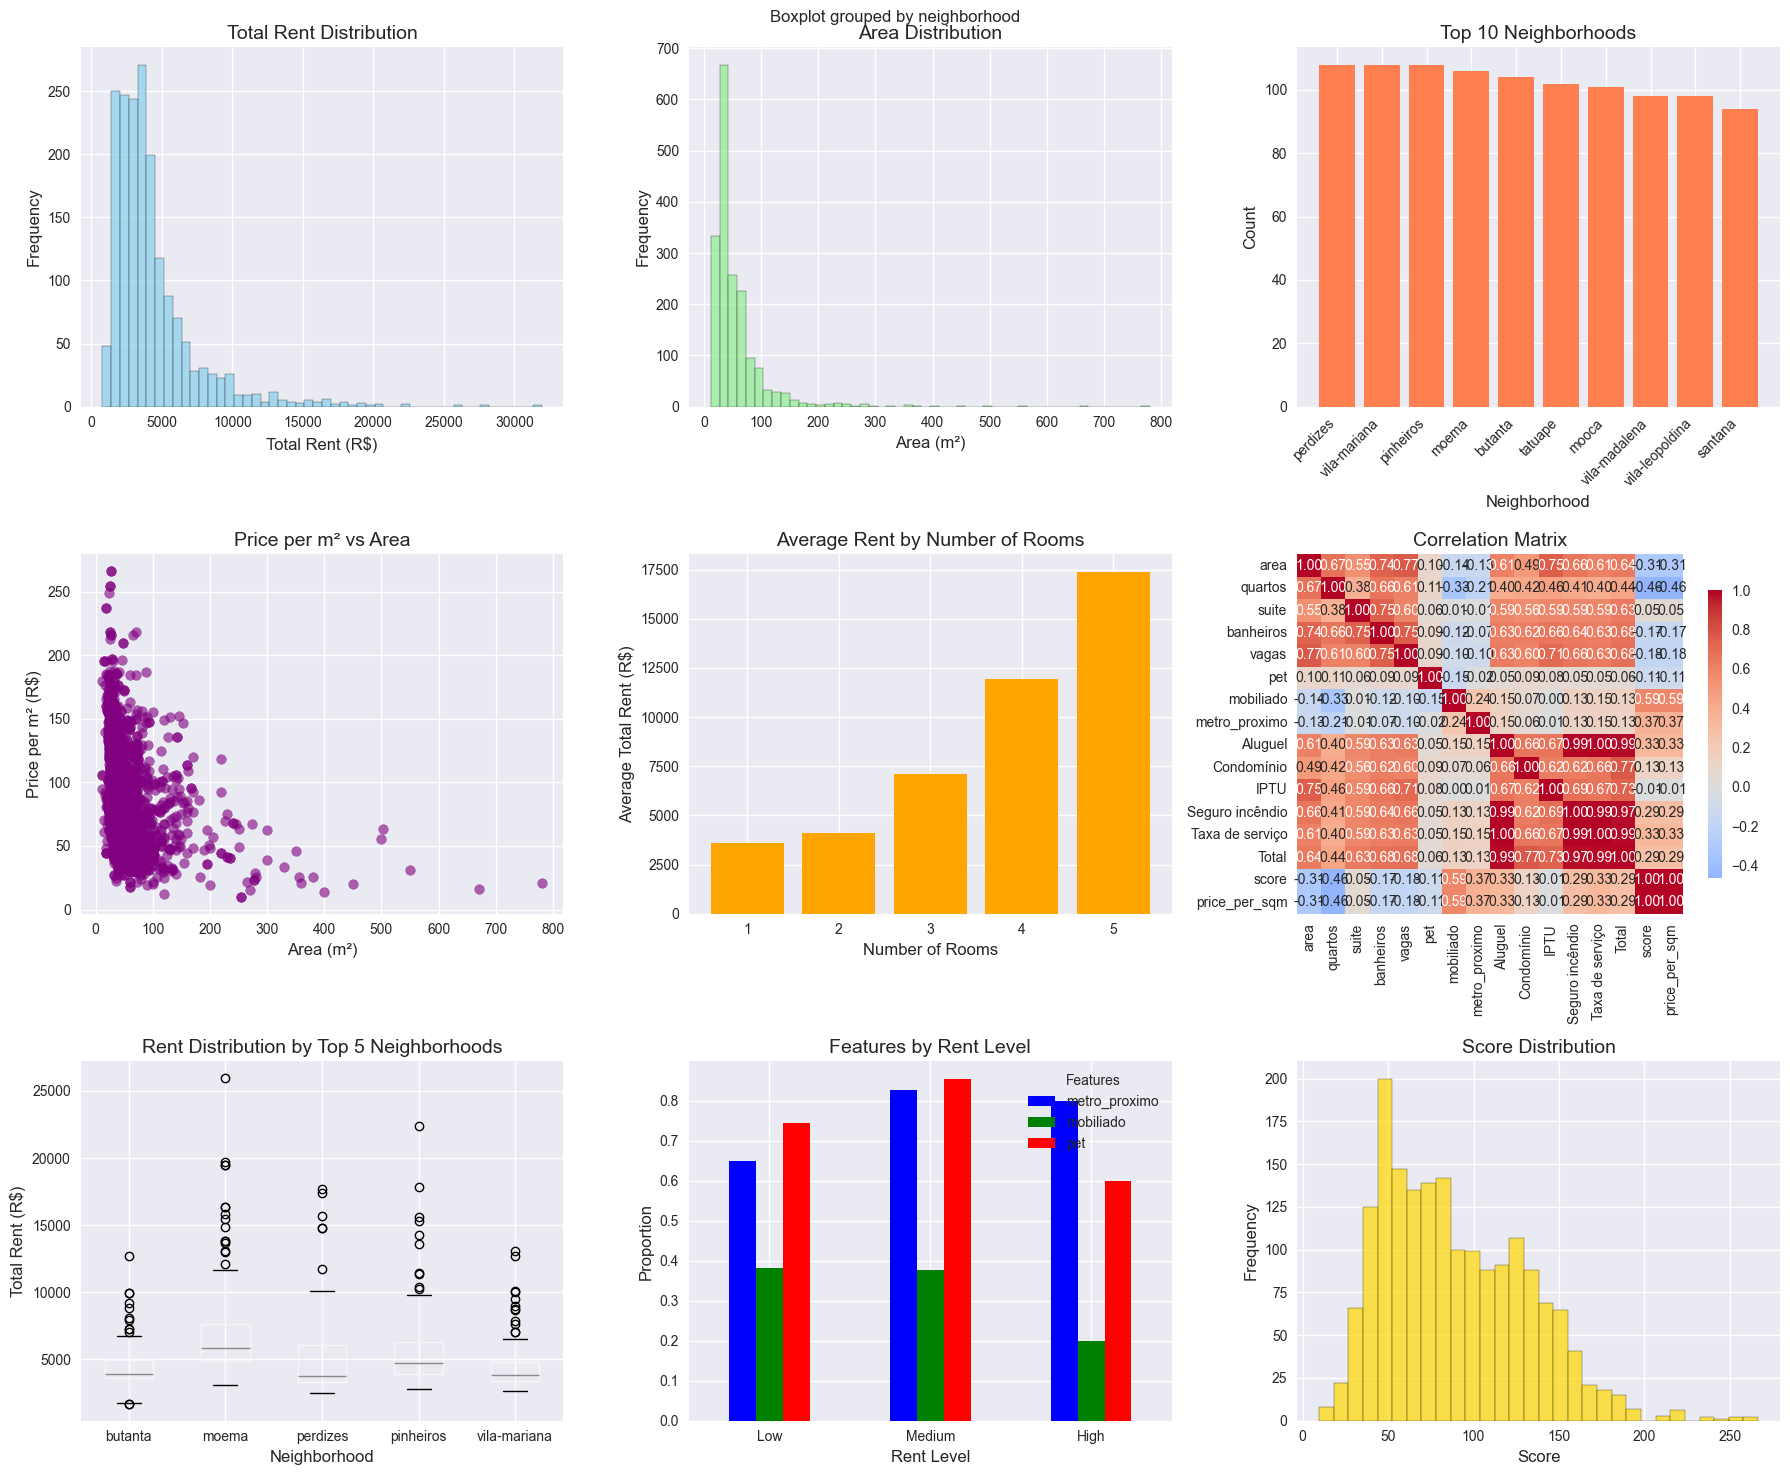

In [41]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('São Paulo Rental Market - Data Distribution', fontsize=16, y=0.98)

# Price distributions
axes[0,0].hist(data['Total'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Total Rent Distribution')
axes[0,0].set_xlabel('Total Rent (R$)')
axes[0,0].set_ylabel('Frequency')

# Area distribution
axes[0,1].hist(data['area'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Area Distribution')
axes[0,1].set_xlabel('Area (m²)')
axes[0,1].set_ylabel('Frequency')

# Neighborhood distribution (top 10)
top_neighborhoods = data['neighborhood'].value_counts().head(10)
axes[0,2].bar(range(len(top_neighborhoods)), top_neighborhoods.values, color='coral')
axes[0,2].set_title('Top 10 Neighborhoods')
axes[0,2].set_xlabel('Neighborhood')
axes[0,2].set_ylabel('Count')
axes[0,2].set_xticks(range(len(top_neighborhoods)))
axes[0,2].set_xticklabels(top_neighborhoods.index, rotation=45, ha='right')

# Price per sqm
data['price_per_sqm'] = data['Total'] / data['area']
axes[1,0].scatter(data['area'], data['price_per_sqm'], alpha=0.6, color='purple')
axes[1,0].set_title('Price per m² vs Area')
axes[1,0].set_xlabel('Area (m²)')
axes[1,0].set_ylabel('Price per m² (R$)')

# Rooms vs price
room_price = data.groupby('quartos')['Total'].mean()
axes[1,1].bar(room_price.index, room_price.values, color='orange')
axes[1,1].set_title('Average Rent by Number of Rooms')
axes[1,1].set_xlabel('Number of Rooms')
axes[1,1].set_ylabel('Average Total Rent (R$)')

# Correlation heatmap
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            ax=axes[1,2], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1,2].set_title('Correlation Matrix')

# Box plot by neighborhood (top 5)
top_5_neighborhoods = data['neighborhood'].value_counts().head(5).index
data_top5 = data[data['neighborhood'].isin(top_5_neighborhoods)]
data_top5.boxplot(column='Total', by='neighborhood', ax=axes[2,0])
axes[2,0].set_title('Rent Distribution by Top 5 Neighborhoods')
axes[2,0].set_xlabel('Neighborhood')
axes[2,0].set_ylabel('Total Rent (R$)')

# Features by rent level
data['rent_level'] = pd.cut(data['Total'], bins=3, labels=['Low', 'Medium', 'High'])
rent_features = data.groupby('rent_level')[['metro_proximo', 'mobiliado', 'pet']].mean()
rent_features.plot(kind='bar', ax=axes[2,1], color=['blue', 'green', 'red'])
axes[2,1].set_title('Features by Rent Level')
axes[2,1].set_xlabel('Rent Level')
axes[2,1].set_ylabel('Proportion')
axes[2,1].legend(title='Features')
axes[2,1].tick_params(axis='x', rotation=0)

# Score distribution
axes[2,2].hist(data['score'], bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[2,2].set_title('Score Distribution')
axes[2,2].set_xlabel('Score')
axes[2,2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



In [42]:
# Create additional features
data_enhanced = data.copy()

# Price-based features
data_enhanced['price_per_room'] = data_enhanced['Total'] / np.maximum(data_enhanced['quartos'], 1)
data_enhanced['price_per_bathroom'] = data_enhanced['Total'] / np.maximum(data_enhanced['banheiros'], 1)
data_enhanced['rent_to_condo_ratio'] = data_enhanced['Aluguel'] / np.maximum(data_enhanced['Condomínio'], 1)

# Size-based features
data_enhanced['rooms_per_area'] = data_enhanced['quartos'] / data_enhanced['area']
data_enhanced['bathrooms_per_area'] = data_enhanced['banheiros'] / data_enhanced['area']

# Luxury indicator
data_enhanced['luxury_score'] = (
    (data_enhanced['suite'] > 0).astype(int) * 2 +
    (data_enhanced['vagas'] > 1).astype(int) * 1 +
    (data_enhanced['mobiliado'] == 1).astype(int) * 1 +
    (data_enhanced['metro_proximo'] == 1).astype(int) * 1
)

print(f"Enhanced dataset shape: {data_enhanced.shape}")
print(f"New features created: {set(data_enhanced.columns) - set(data.columns)}")

# Improved preprocessing pipeline
print("\n" + "="*50)
print("PREPROCESSING PIPELINE")
print("="*50)

# Define feature groups
numerical_features = [
    'area', 'quartos', 'suite', 'banheiros', 'vagas',
    'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço', 'Total',
    'price_per_sqm', 'price_per_room', 'price_per_bathroom', 'rent_to_condo_ratio',
    'rooms_per_area', 'bathrooms_per_area', 'luxury_score'
]

categorical_features = ['neighborhood']

binary_features = ['pet', 'mobiliado', 'metro_proximo']

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # More robust to outliers than StandardScaler
    ('pca', PCA(n_components=0.9, random_state=42))  # Keep 95% of variance
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine all preprocessing
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
    ('bin', StandardScaler(), binary_features)
], remainder='drop')

# Prepare data for clustering
X = data_enhanced[numerical_features + categorical_features + binary_features].copy()

print(f"Features for clustering: {X.columns.tolist()}")
print(f"Data shape: {X.shape}")

# Fit preprocessing pipeline
X_processed = preprocessor.fit_transform(X)
print(f"Processed data shape: {X_processed.shape}")

# Get number of PCA components
n_pca_components = preprocessor.named_transformers_['num'].named_steps['pca'].n_components_
explained_var_ratio = preprocessor.named_transformers_['num'].named_steps['pca'].explained_variance_ratio_
cumsum_var = np.cumsum(explained_var_ratio)

print(f"PCA components: {n_pca_components}")
print(f"Explained variance: {cumsum_var[-1]:.3f}")





Enhanced dataset shape: (1809, 24)
New features created: {'price_per_bathroom', 'price_per_room', 'luxury_score', 'rooms_per_area', 'bathrooms_per_area', 'rent_to_condo_ratio'}

PREPROCESSING PIPELINE
Features for clustering: ['area', 'quartos', 'suite', 'banheiros', 'vagas', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço', 'Total', 'price_per_sqm', 'price_per_room', 'price_per_bathroom', 'rent_to_condo_ratio', 'rooms_per_area', 'bathrooms_per_area', 'luxury_score', 'neighborhood', 'pet', 'mobiliado', 'metro_proximo']
Data shape: (1809, 22)
Processed data shape: (1809, 28)
PCA components: 6
Explained variance: 0.920


In [43]:
# Prepare data for clustering
X = data_enhanced[numerical_features + categorical_features + binary_features].copy()

print(f"Features for clustering: {X.columns.tolist()}")
print(f"Data shape: {X.shape}")

# Fit preprocessing pipeline
X_processed = preprocessor.fit_transform(X)
print(f"Processed data shape: {X_processed.shape}")

# Get number of PCA components
n_pca_components = preprocessor.named_transformers_['num'].named_steps['pca'].n_components_
explained_var_ratio = preprocessor.named_transformers_['num'].named_steps['pca'].explained_variance_ratio_
cumsum_var = np.cumsum(explained_var_ratio)

print(f"PCA components: {n_pca_components}")
print(f"Explained variance: {cumsum_var[-1]:.3f}")



Features for clustering: ['area', 'quartos', 'suite', 'banheiros', 'vagas', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço', 'Total', 'price_per_sqm', 'price_per_room', 'price_per_bathroom', 'rent_to_condo_ratio', 'rooms_per_area', 'bathrooms_per_area', 'luxury_score', 'neighborhood', 'pet', 'mobiliado', 'metro_proximo']
Data shape: (1809, 22)
Processed data shape: (1809, 28)
PCA components: 6
Explained variance: 0.920



OPTIMAL CLUSTER ANALYSIS
Evaluating cluster numbers...
Optimal k (Elbow method): 6
Optimal k (Silhouette score): 2


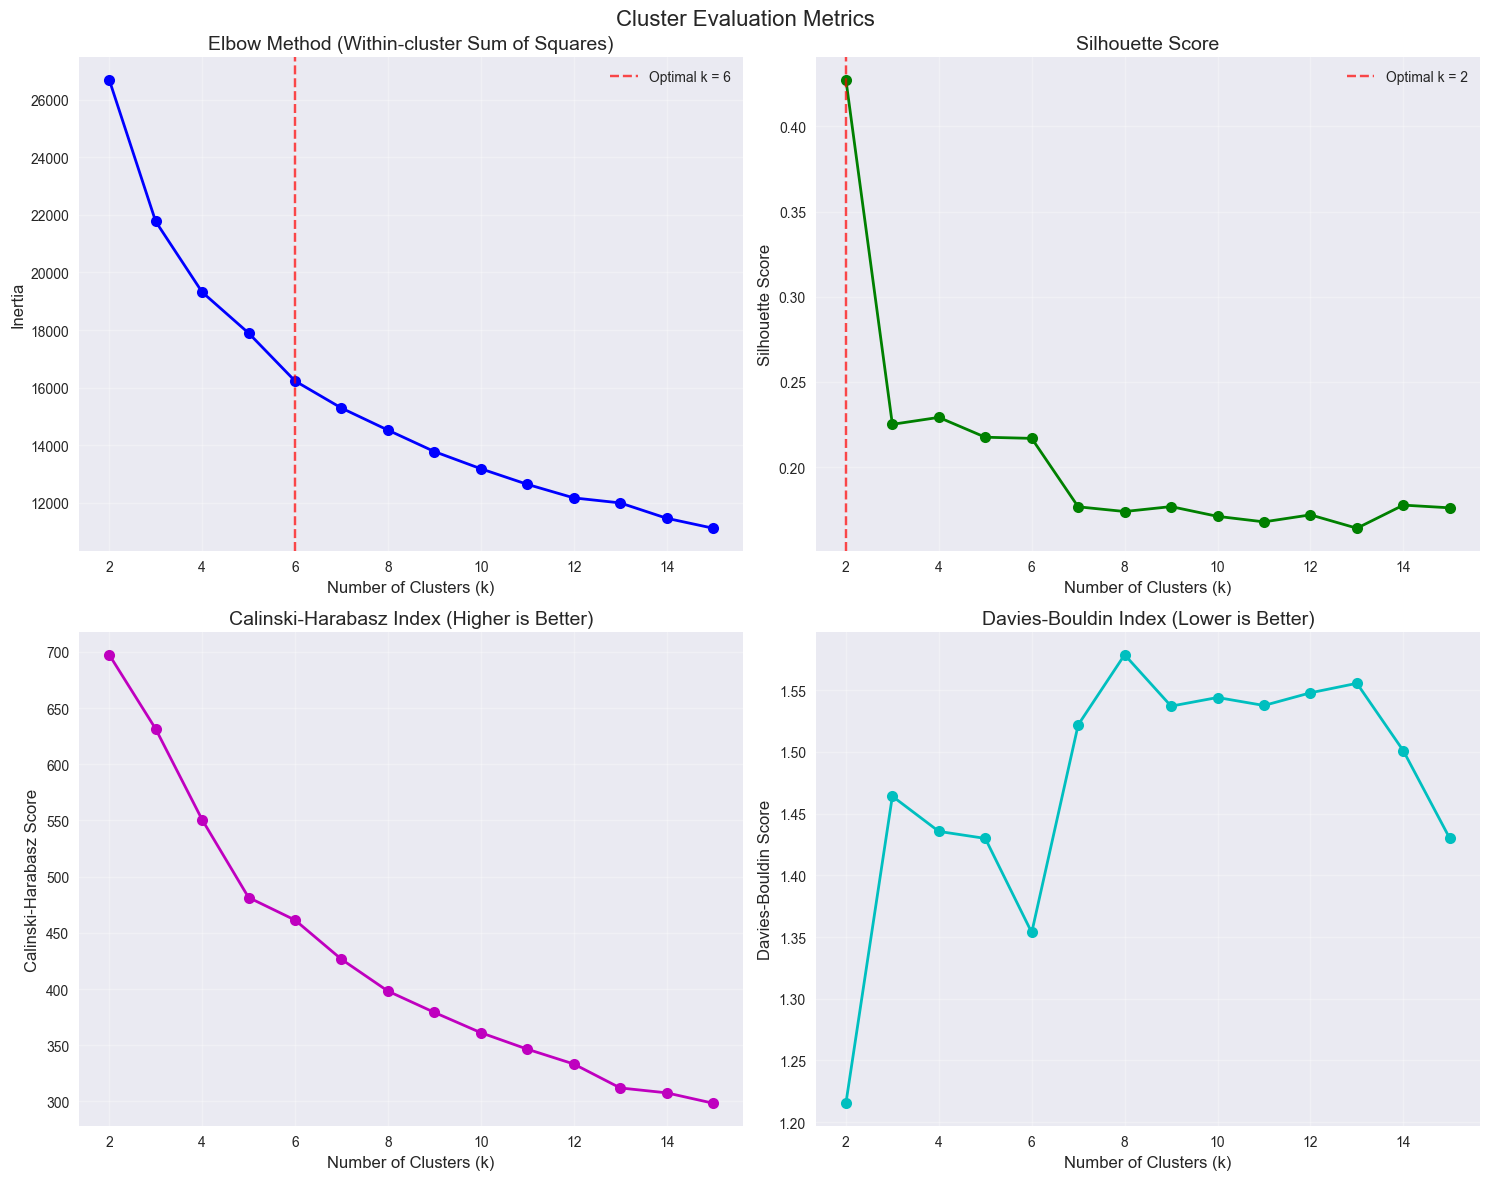


Using k = 6 clusters for final analysis

FINAL CLUSTERING ANALYSIS
Final silhouette score: 0.217
Final Davies-Bouldin score: 1.354

Cluster sizes:
Cluster 0: 536 properties (29.6%)
Cluster 1: 716 properties (39.6%)
Cluster 2: 216 properties (11.9%)
Cluster 3: 13 properties (0.7%)
Cluster 4: 81 properties (4.5%)
Cluster 5: 247 properties (13.7%)

CLUSTER CHARACTERIZATION
Cluster Profiles (Key Metrics):

CLUSTER 0 (536 properties - 29.6%):
  • Average area: 30.2 m² (median: 28.0)
  • Average rent: R$ 3658 (median: R$ 3656)
  • Average price/m²: R$ 125
  • Average rooms: 1.1
  • Near metro: 86%
  • Furnished: 82%
  • Pet-friendly: 64%
  • Top neighborhoods: vila-mariana, perdizes, pinheiros

CLUSTER 1 (716 properties - 39.6%):
  • Average area: 43.2 m² (median: 40.0)
  • Average rent: R$ 2369 (median: R$ 2196)
  • Average price/m²: R$ 59
  • Average rooms: 1.7
  • Near metro: 47%
  • Furnished: 6%
  • Pet-friendly: 77%
  • Top neighborhoods: vila-maria, penha, itaquera

CLUSTER 2 (216 pr

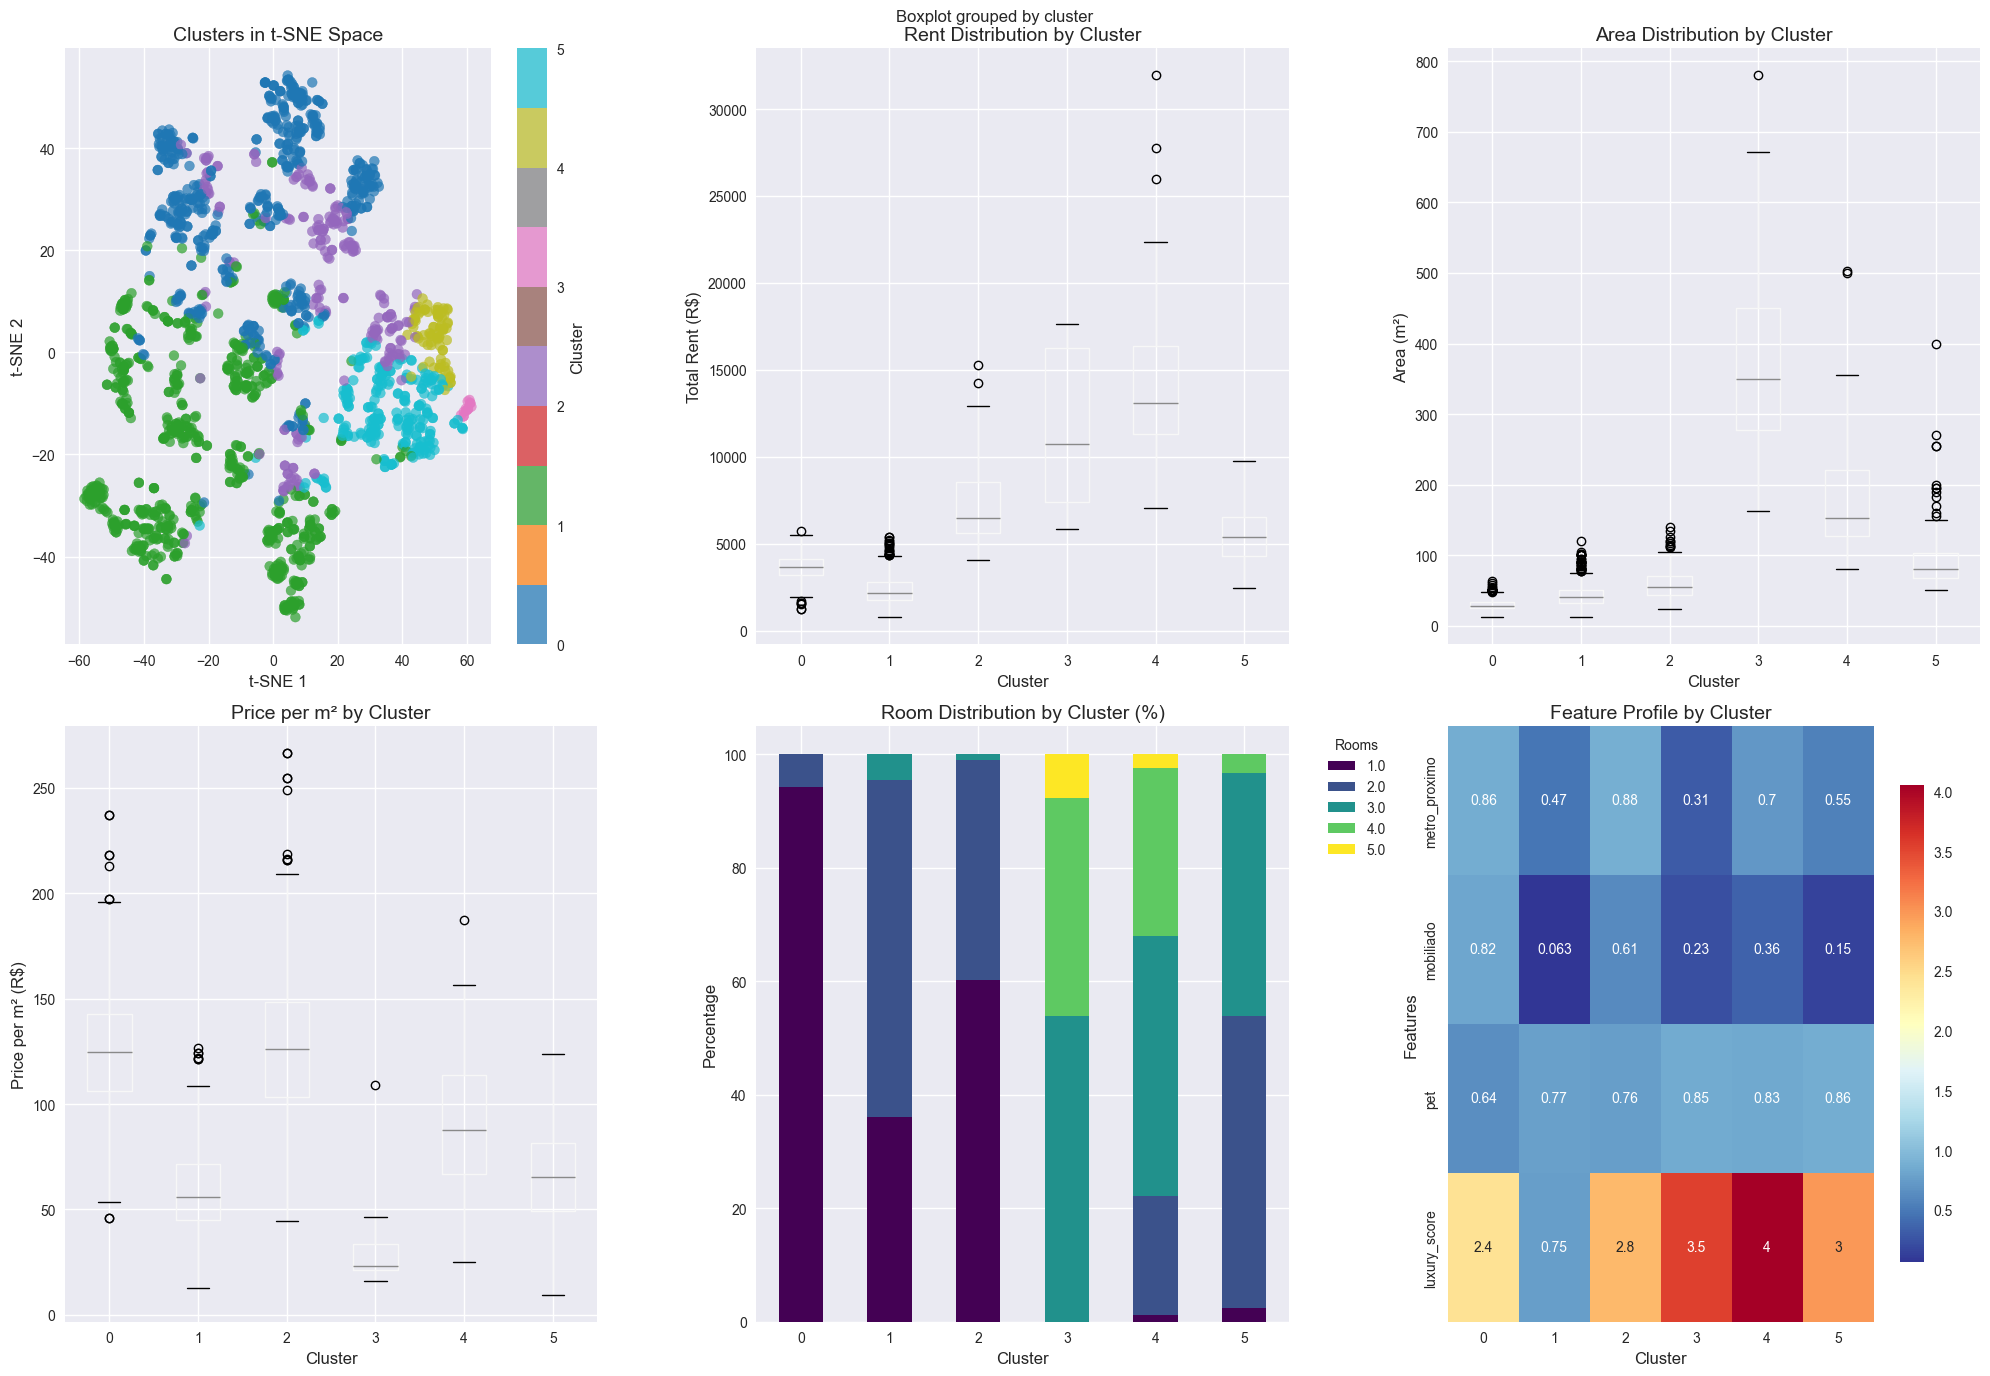


BUSINESS INSIGHTS AND RECOMMENDATIONS
MARKET SEGMENTS IDENTIFIED:
----------------------------------------

ECONOMY SEGMENT (Cluster 1):
  Market Size: 716 properties (39.6% of market)
  Avg Rent: R$ 2369
  Avg Area: 43.2 m²
  Price/m²: R$ 59
  Key Location: vila-maria
  Luxury Level: 0.8/4
  Metro Access: 47%

BUDGET-FRIENDLY SEGMENT (Cluster 0):
  Market Size: 536 properties (29.6% of market)
  Avg Rent: R$ 3658
  Avg Area: 30.2 m²
  Price/m²: R$ 125
  Key Location: vila-mariana
  Luxury Level: 2.4/4
  Metro Access: 86%

MID-MARKET SEGMENT (Cluster 5):
  Market Size: 247 properties (13.7% of market)
  Avg Rent: R$ 5525
  Avg Area: 91.5 m²
  Price/m²: R$ 66
  Key Location: tatuape
  Luxury Level: 3.0/4
  Metro Access: 55%

UPPER-MID SEGMENT (Cluster 2):
  Market Size: 216 properties (11.9% of market)
  Avg Rent: R$ 7081
  Avg Area: 58.9 m²
  Price/m²: R$ 129
  Key Location: moema
  Luxury Level: 2.8/4
  Metro Access: 88%

PREMIUM SEGMENT (Cluster 3):
  Market Size: 13 properties (0.7

In [44]:
# Optimal number of clusters analysis
print("\n" + "="*50)
print("OPTIMAL CLUSTER ANALYSIS")
print("="*50)

# Comprehensive cluster evaluation
k_range = range(2, 16)
metrics = {
    'inertia': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

print("Evaluating cluster numbers...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_processed)
    
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_processed, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_processed, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_processed, labels))

# Find optimal k using elbow method
def find_elbow_point(inertias):
    """Find elbow point using the point of maximum curvature"""
    n_points = len(inertias)
    all_coords = np.vstack((range(n_points), inertias)).T
    first_point = all_coords[0]
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    return np.argmax(dist_to_line) + k_range[0]

optimal_k_elbow = find_elbow_point(metrics['inertia'])

# Find optimal k using silhouette score
optimal_k_silhouette = k_range[np.argmax(metrics['silhouette'])]

print(f"Optimal k (Elbow method): {optimal_k_elbow}")
print(f"Optimal k (Silhouette score): {optimal_k_silhouette}")

# Plot cluster evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cluster Evaluation Metrics', fontsize=16)

# Elbow curve
axes[0,0].plot(k_range, metrics['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0,0].axvline(x=optimal_k_elbow, color='red', linestyle='--', alpha=0.7, label=f'Optimal k = {optimal_k_elbow}')
axes[0,0].set_title('Elbow Method (Within-cluster Sum of Squares)')
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Inertia')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Silhouette score
axes[0,1].plot(k_range, metrics['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0,1].axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, label=f'Optimal k = {optimal_k_silhouette}')
axes[0,1].set_title('Silhouette Score')
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# Calinski-Harabasz Index
axes[1,0].plot(k_range, metrics['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1,0].set_title('Calinski-Harabasz Index (Higher is Better)')
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Calinski-Harabasz Score')
axes[1,0].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[1,1].plot(k_range, metrics['davies_bouldin'], 'co-', linewidth=2, markersize=8)
axes[1,1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Davies-Bouldin Score')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Use the optimal number of clusters
optimal_k = optimal_k_elbow
print(f"\nUsing k = {optimal_k} clusters for final analysis")

# Final clustering
print("\n" + "="*50)
print("FINAL CLUSTERING ANALYSIS")
print("="*50)

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
cluster_labels = final_kmeans.fit_predict(X_processed)

# Add cluster labels to original data
data_clustered = data_enhanced.copy()
data_clustered['cluster'] = cluster_labels

# Cluster analysis
print(f"Final silhouette score: {silhouette_score(X_processed, cluster_labels):.3f}")
print(f"Final Davies-Bouldin score: {davies_bouldin_score(X_processed, cluster_labels):.3f}")

print("\nCluster sizes:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"Cluster {cluster_id}: {count} properties ({percentage:.1f}%)")

# Cluster characterization
print("\n" + "="*50)
print("CLUSTER CHARACTERIZATION")
print("="*50)

# Analyze cluster characteristics
cluster_profiles = data_clustered.groupby('cluster').agg({
    'area': ['mean', 'median', 'std'],
    'quartos': ['mean', 'median'],
    'banheiros': ['mean', 'median'],
    'vagas': ['mean', 'median'],
    'Total': ['mean', 'median', 'std'],
    'price_per_sqm': ['mean', 'median'],
    'luxury_score': ['mean', 'median'],
    'metro_proximo': 'mean',
    'mobiliado': 'mean',
    'pet': 'mean'
}).round(2)

print("Cluster Profiles (Key Metrics):")
print("=" * 80)
for cluster_id in sorted(data_clustered['cluster'].unique()):
    cluster_data = data_clustered[data_clustered['cluster'] == cluster_id]
    print(f"\nCLUSTER {cluster_id} ({len(cluster_data)} properties - {len(cluster_data)/len(data_clustered)*100:.1f}%):")
    print(f"  • Average area: {cluster_data['area'].mean():.1f} m² (median: {cluster_data['area'].median():.1f})")
    print(f"  • Average rent: R$ {cluster_data['Total'].mean():.0f} (median: R$ {cluster_data['Total'].median():.0f})")
    print(f"  • Average price/m²: R$ {cluster_data['price_per_sqm'].mean():.0f}")
    print(f"  • Average rooms: {cluster_data['quartos'].mean():.1f}")
    print(f"  • Near metro: {cluster_data['metro_proximo'].mean()*100:.0f}%")
    print(f"  • Furnished: {cluster_data['mobiliado'].mean()*100:.0f}%")
    print(f"  • Pet-friendly: {cluster_data['pet'].mean()*100:.0f}%")
    print(f"  • Top neighborhoods: {', '.join(cluster_data['neighborhood'].value_counts().head(3).index.tolist())}")

# Visualize clusters
print("\n" + "="*50)
print("CLUSTER VISUALIZATION")
print("="*50)

# Create cluster visualization using t-SNE for 2D representation
print("Generating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_processed)//4))
X_tsne = tsne.fit_transform(X_processed)

# Create comprehensive cluster plots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle(f'Cluster Analysis Results (k={optimal_k})', fontsize=16)

# t-SNE scatter plot
scatter = axes[0,0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
axes[0,0].set_title('Clusters in t-SNE Space')
axes[0,0].set_xlabel('t-SNE 1')
axes[0,0].set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=axes[0,0], label='Cluster')

# Cluster vs Total Rent
data_clustered.boxplot(column='Total', by='cluster', ax=axes[0,1])
axes[0,1].set_title('Rent Distribution by Cluster')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Total Rent (R$)')

# Cluster vs Area
data_clustered.boxplot(column='area', by='cluster', ax=axes[0,2])
axes[0,2].set_title('Area Distribution by Cluster')
axes[0,2].set_xlabel('Cluster')
axes[0,2].set_ylabel('Area (m²)')

# Price per sqm by cluster
data_clustered.boxplot(column='price_per_sqm', by='cluster', ax=axes[1,0])
axes[1,0].set_title('Price per m² by Cluster')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Price per m² (R$)')

# Cluster composition by number of rooms
cluster_rooms = pd.crosstab(data_clustered['cluster'], data_clustered['quartos'], normalize='index') * 100
cluster_rooms.plot(kind='bar', stacked=True, ax=axes[1,1], colormap='viridis')
axes[1,1].set_title('Room Distribution by Cluster (%)')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Percentage')
axes[1,1].legend(title='Rooms', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=0)

# Features heatmap by cluster
feature_cols = ['metro_proximo', 'mobiliado', 'pet', 'luxury_score']
cluster_features = data_clustered.groupby('cluster')[feature_cols].mean()
sns.heatmap(cluster_features.T, annot=True, cmap='RdYlBu_r', ax=axes[1,2], cbar_kws={'shrink': 0.8})
axes[1,2].set_title('Feature Profile by Cluster')
axes[1,2].set_xlabel('Cluster')
axes[1,2].set_ylabel('Features')

plt.tight_layout()
plt.show()

# Business insights and recommendations
print("\n" + "="*60)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Calculate cluster insights
insights = {}
for cluster_id in sorted(data_clustered['cluster'].unique()):
    cluster_data = data_clustered[data_clustered['cluster'] == cluster_id]
    insights[cluster_id] = {
        'size': len(cluster_data),
        'avg_rent': cluster_data['Total'].mean(),
        'avg_area': cluster_data['area'].mean(),
        'avg_price_per_sqm': cluster_data['price_per_sqm'].mean(),
        'top_neighborhood': cluster_data['neighborhood'].mode().iloc[0],
        'luxury_score': cluster_data['luxury_score'].mean(),
        'metro_access': cluster_data['metro_proximo'].mean()
    }

# Sort clusters by average rent for easier interpretation
sorted_clusters = sorted(insights.keys(), key=lambda x: insights[x]['avg_rent'])

print("MARKET SEGMENTS IDENTIFIED:")
print("-" * 40)

segment_names = ['Economy', 'Budget-Friendly', 'Mid-Market', 'Upper-Mid', 'Premium', 'Luxury', 'Ultra-Luxury', 'Exclusive']

for i, cluster_id in enumerate(sorted_clusters):
    segment_name = segment_names[i] if i < len(segment_names) else f'Segment {i+1}'
    data = insights[cluster_id]
    
    print(f"\n{segment_name.upper()} SEGMENT (Cluster {cluster_id}):")
    print(f"  Market Size: {data['size']} properties ({data['size']/len(data_clustered)*100:.1f}% of market)")
    print(f"  Avg Rent: R$ {data['avg_rent']:.0f}")
    print(f"  Avg Area: {data['avg_area']:.1f} m²")
    print(f"  Price/m²: R$ {data['avg_price_per_sqm']:.0f}")
    print(f"  Key Location: {data['top_neighborhood']}")
    print(f"  Luxury Level: {data['luxury_score']:.1f}/4")
    print(f"  Metro Access: {data['metro_access']*100:.0f}%")

print(f"\n{'='*60}")
print("KEY RECOMMENDATIONS:")
print("-" * 20)
print("1. PRICING STRATEGY: Use cluster-based pricing models for accurate rent estimation")
print("2. MARKET TARGETING: Focus marketing efforts on underrepresented high-value segments")
print("3. INVESTMENT OPPORTUNITIES: Clusters with high price/m² ratios indicate premium markets")
print("4. FEATURE OPTIMIZATION: Properties near metro with luxury features command premium rents")
print("5. GEOGRAPHIC FOCUS: Concentrate inventory acquisition in top-performing neighborhoods per cluster")

# Save results
data_clustered.to_csv(r'D:\Tech-Challenge-QuintoAndar\database\clustered_rental_data.csv', index=False)
print(f"\nResults saved to 'clustered_rental_data.csv'")
print(f"Total properties analyzed: {len(data_clustered)}")
print(f"Clusters identified: {optimal_k}")
print(f"Final model performance (Silhouette Score): {silhouette_score(X_processed, cluster_labels):.3f}")